In [1]:
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as pl
from pandas_datareader.data import DataReader
from statsmodels import regression


In [2]:
def linear_regression(x,y):
    x = sm.add_constant(x)
    model = regression.linear_model.OLS(y,x).fit()
    x = x[:, 1]
    return model.params[0], model.params[1]

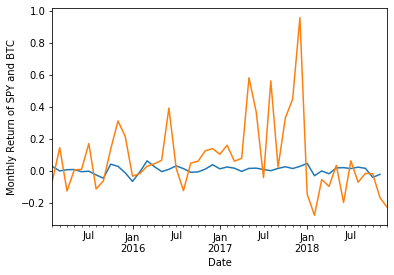

In [3]:
BTC = DataReader('BTC-USD',  'yahoo', '2015-01-01', '2018-12-01')
SPY = DataReader('SPY',  'yahoo', '2015-01-01', '2018-12-01')
BTC_return_monthly = BTC.groupby(pd.Grouper(freq='MS'))['Adj Close'].mean()
BTC_return_monthly = BTC_return_monthly.pct_change()[1:]
SPY_return_monthly = SPY.groupby(pd.Grouper(freq='MS'))['Adj Close'].mean()
SPY_return_monthly = SPY_return_monthly.pct_change()[1:]
SPY_return_monthly.plot()
BTC_return_monthly.plot()
pl.ylabel("Monthly Return of SPY and BTC")
pl.show()

In [4]:
BTC_return_monthly = BTC_return_monthly[:46]
if BTC_return_monthly.shape == SPY_return_monthly.shape:
    pass
else:
    raise exception("Shapes don't match.")

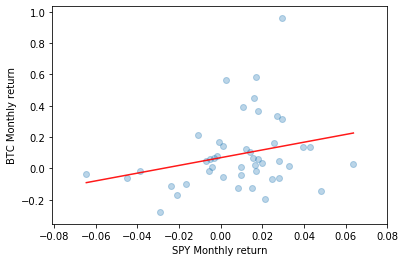

Alpha = 0.06891185022495161

R_Value = 0.26342063094725393

Slope = 2.4674913845629245

Std_Err = 1.3622702693219628



In [5]:
X = SPY_return_monthly.values
Y = BTC_return_monthly.values
Alpha, Beta = linear_regression(X,Y)
X2 = np.linspace(X.min(), X.max(), 100)
Y_tilda = X2* Beta + Alpha
pl.scatter(X,Y, alpha = 0.3)
pl.xlabel("SPY Monthly return")
pl.ylabel("BTC Monthly return")
pl.plot(X2, Y_tilda, 'r', alpha = 0.9)
pl.show()

Slope, Intercept, R_Value, P_Value, Std_Err = scipy.stats.linregress(X, Y)
print("Alpha = " + str(Alpha) + "\n")
print("R_Value = " +  str(R_Value) + "\n")
print("Slope = " +   str(Slope) + "\n")
print("Std_Err = " +  str(Std_Err) + "\n")

In [8]:
import pymc3 as pm
lin_model = pm.Model()

with lin_model:
    intercept = pm.Normal('intercept',mu=0, sd = 20)
    beta = pm.Normal('beta',0, sd = 20)
    sigma = pm.HalfCauchy('sigma', beta = 10)
    likelihood = pm.Normal('Y', mu = intercept + beta * X, sd = sigma, observed = Y)
    trace = pm.sample(3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, intercept]
Sampling 2 chains: 100%|██████████| 7000/7000 [00:06<00:00, 1150.18draws/s]


In [ ]:
pl.figure(figsize=(7, 7))
pm.traceplot(trace[100:])
pl.tight_layout();

In [ ]:
pm.plot_posterior(trace)

In [ ]:
import numpy as np
n_samples = 500
x_range = np.linspace(X.min(),X.max())
for i in np.arange(n_samples,step=10):
    yhat = trace['intercept'][i] + trace['beta'][i] * x_range
    pl.plot(x_range,yhat,color='k',alpha = 0.2)
    pl.scatter(X,Y,color='r',marker='+')
    pl.ylabel('BTC monthly return')
    pl.xlabel('SPY monthly return')

In [ ]:
pm.summary(trace)

In [ ]:
pm.forestplot(trace)

In [ ]:
diverging = trace['diverging']
print('Number of Divergent Chains: {}'.format(diverging.nonzero()[0].size))
diverging_perc = diverging.nonzero()[0].size / len(trace) * 100
print('Percentage of Divergent Chains: {:.1f}'.format(diverging_perc))

In [9]:
pm.stats.waic(trace, model= lin_model, pointwise= False, progressbar=False)

/usr/local/lib/python3.7/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


WAIC_r(WAIC=-1.7800575209710137, WAIC_se=16.443297542601403, p_WAIC=3.9519504008853352, var_warn=1)